In [21]:
!pip uninstall -y oao24
!pip install git+https://github.com/ArcetriAdaptiveOptics/OAO24.git

Found existing installation: oao24 0.1
Uninstalling oao24-0.1:
  Successfully uninstalled oao24-0.1
  Cloning https://github.com/ArcetriAdaptiveOptics/OAO24.git to /private/var/folders/yy/y6mh4b390sj24kqkcp9nl2c40000gp/T/pip-req-build-b1t_di9u
  Running command git clone --filter=blob:none --quiet https://github.com/ArcetriAdaptiveOptics/OAO24.git /private/var/folders/yy/y6mh4b390sj24kqkcp9nl2c40000gp/T/pip-req-build-b1t_di9u
  Resolved https://github.com/ArcetriAdaptiveOptics/OAO24.git to commit 6946bb36a1274b90a07d39ebaf3a536af80d1079
  Preparing metadata (setup.py) ... done
  Created wheel for oao24: filename=oao24-0.1-py3-none-any.whl size=13724613 sha256=2ade484aa5377e3c0b0004f8a78c37b00471e158c7937ca86cbb2f1f97beaca9
  Stored in directory: /private/var/folders/yy/y6mh4b390sj24kqkcp9nl2c40000gp/T/pip-ephem-wheel-cache-n4pm03fo/wheels/7a/76/63/a40f38a93ba61eeeed0e55302f7271eed0e932d99461d44bf8
Successfully built oao24


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from oao24.package_data import InfraredExampleData, VisibleExampleData
from oao24 import image_processing

Master image : ROIs mean values 2.12017 2.77187 1.11106 2.13341 - Average 2.03413 ADU


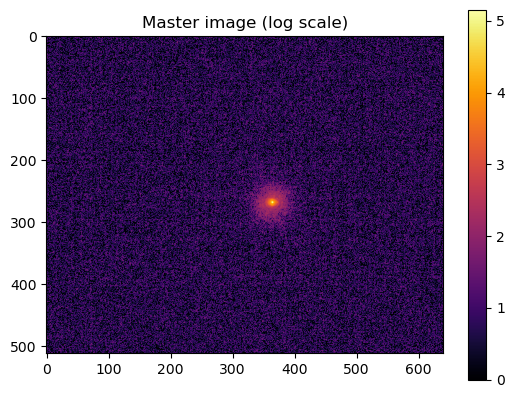

In [23]:
background_image = InfraredExampleData.get_camera_dark_data()
cl_raw_image_cube = InfraredExampleData.get_close_loop_data_cube()
ao_image = image_processing.make_master_image(cl_raw_image_cube, background_image)

In [24]:

RAD2ARCSEC=180/np.pi*3600
pupil_diameter = 1.52 
wavelength = 1.65e-6 # 1310e-9
# Plate scale is typically saved in the FITS image header
# or it can be calibrated using 2 sources of known distance
# Here we use the Papyrus nominal optical design values
# F/# = 23
# The DL PSF size in m on the focal is F/H * wavelength
cred3_pixel_in_meter = 15e-6
f_number =  23
telescope_focal_length = f_number * pupil_diameter
# so the size of the pixel in arcsec is 
pixel_scale_in_arcsec =cred3_pixel_in_meter / telescope_focal_length * RAD2ARCSEC 

# the DL size (=lambda/D) in units of arcsec or pixels are therefore
dl_size_in_arcsec = wavelength / pupil_diameter * RAD2ARCSEC 
dl_size_in_pixels = dl_size_in_arcsec / pixel_scale_in_arcsec

print("C-Red3 pixel scale: %g arcsec/pixel" % pixel_scale_in_arcsec)
print("DL PSF size: %g arcsec" % dl_size_in_arcsec)
print("DL PSF size: %g pixels" % dl_size_in_pixels)


C-Red3 pixel scale: 0.0885003 arcsec/pixel
DL PSF size: 0.223906 arcsec
DL PSF size: 2.53 pixels


In [ ]:

star_roi = ao_image[240:296, 335:391]
star_roi_cut_index = (29, slice(15, 45))

In [25]:

#SR estimation assuming a gaussian model
amp = star_roi.max()
x0 = np.where(star_roi == star_roi.max())[1][0]
y0 = np.where(star_roi == star_roi.max())[0][0]
sigma_x = 2.5/(2*np.sqrt(2*np.log(2)))
sigma_y = sigma_x
model_gauss = models.Gaussian2D(amp, x0, y0, sigma_x, sigma_y)
fitter = fitting.LevMarLSQFitter()
roi_shape = star_roi.shape
y, x = np.mgrid[:roi_shape[0], :roi_shape[1]]
best_fit_gauss = fitter(model_gauss, x, y, z = star_roi)
psf_residual_gauss= best_fit_gauss(x,y)-star_roi


In [26]:

Ntot = star_roi.sum()

alpha = np.pi/(f_number*wavelength)*15e-6
amp_dl  = 3 *alpha* Ntot / 32
sr = best_fit_gauss.parameters[0]/amp_dl
#computing SR from fft of pupil


### Create DL PSF from pupil mask

Pupil padding 2.53
Computed DL PSF scale 0.0885003
Max(DL PSF normalized) 218240
Max(Measured PSF) 142190
SR: 0.65153


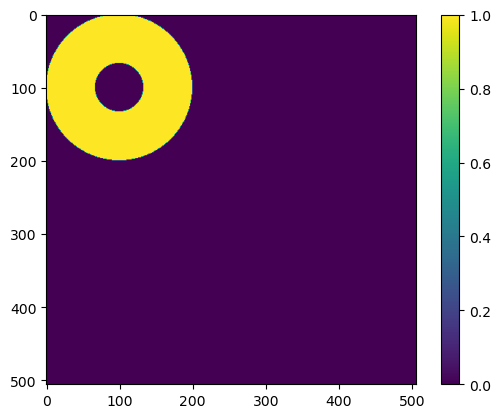

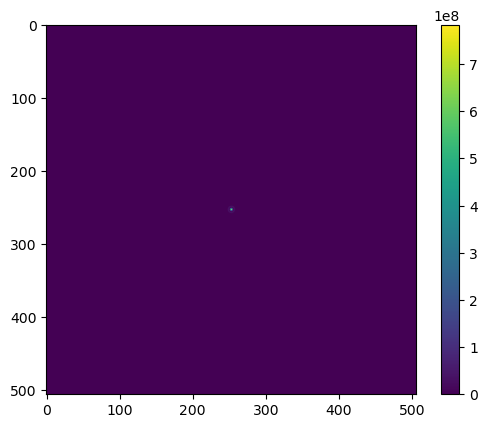

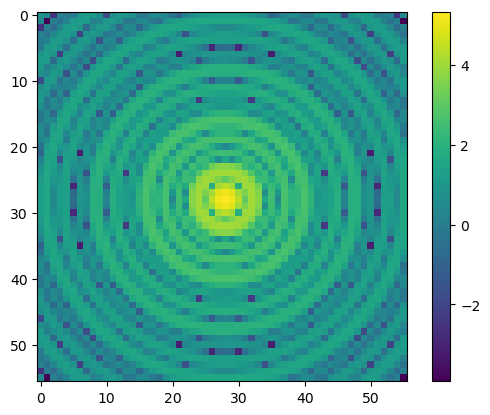

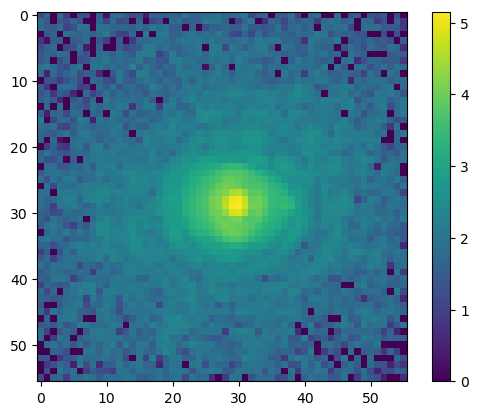

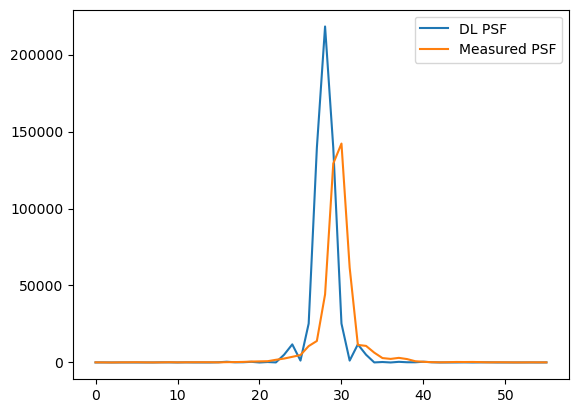

In [56]:

from oao24.mask import AnnularMask
def compute_psf_dl(Npix, obs_radius_in_pix, wavelength, pupil_diameter, pixel_scale_in_arcsec):
    pupil = np.zeros((Npix,Npix))
    pupil_radius_in_pix = Npix/2
    

    pupil_mask_obj = AnnularMask(
        frameShape=pupil.shape,
        maskRadius=pupil_radius_in_pix,
        inRadius=obs_radius_in_pix)

    pupil_mask = pupil_mask_obj.mask()
    phase = np.ma.array(pupil, mask = pupil_mask)

    # computing transmitted electric field
    Ut = 1 * np.exp(1j * phase)
    Ut.fill_value = 0
    Ut.data[Ut.mask == True] = 0

    # padding transmitted electric field to match resulting px scale with the instrument pixel scale
    Npad = wavelength / pupil_diameter  * RAD2ARCSEC /  pixel_scale_in_arcsec
    print("Pupil padding %g" % Npad)
    padded_frame_size = int(np.round(Npix * Npad))
    padded_Ut = np.zeros((padded_frame_size, padded_frame_size), dtype=complex)
    padded_Ut[0 : Ut.shape[0], 0 : Ut.shape[1]] = Ut   

    plt.figure()
    plt.imshow(np.abs(padded_Ut))
    plt.colorbar()


    #computing psf
    dl_psf = np.abs(np.fft.fftshift(np.fft.fft2(padded_Ut)))**2
    plt.figure()
    plt.imshow(dl_psf)
    plt.colorbar()

    dl_psf_scale_in_arcsec = wavelength / pupil_diameter / Npad * RAD2ARCSEC

    return dl_psf, dl_psf_scale_in_arcsec

Npix = 200
pupil_radius_in_pix = Npix/2
obstruction_radius_in_pix = 0.33*pupil_radius_in_pix
dl_psf, dl_psf_scale_in_arcsec = compute_psf_dl(Npix, obstruction_radius_in_pix, wavelength, pupil_diameter, pixel_scale_in_arcsec)
print("Computed DL PSF scale %g" % dl_psf_scale_in_arcsec)


total_dl_flux = dl_psf.sum()
total_meas_flux = star_roi.sum()
dl_psf_norm = dl_psf * total_meas_flux/total_dl_flux
cc=(dl_psf_norm.shape[0]) // 2
dl_psf_norm_roi = dl_psf_norm[cc-28:cc+28, cc-28:cc+28]

plt.figure()
plt.imshow(np.log10(dl_psf_norm_roi))
plt.colorbar()
plt.figure()
plt.imshow(np.log10(np.clip(star_roi,0,None)+1))
plt.colorbar()

print("Max(DL PSF normalized) %g" % dl_psf_norm_roi.max())
print("Max(Measured PSF) %g" % star_roi.max())
strehl_ratio = star_roi.max() / dl_psf_norm_roi.max()
print("SR: %g" % strehl_ratio)


plt.figure()
plt.plot(dl_psf_norm_roi[28,:], label='DL PSF')
plt.plot(star_roi[29,:], label='Measured PSF')
plt.legend()


Several limitation in this approach
1. center of star roi
1. background subtraction is very important
1. ....